In [2]:

import matplotlib.pyplot as plt 
import numpy as np 
import os 
import mne.stats as mstats
from scipy.stats import spearmanr
import scipy.io
from scipy.io import loadmat
from sklearn.metrics.pairwise import cosine_similarity


In [6]:
DataPath = 'Results/' 

fname='Results_diss_babies_pooled_decode_within_SVM_02.28.2024_16.29.56.mat'

data = loadmat(DataPath+fname)['results'][0,0]
DA = data['DA']
times=data['times']
epoch=len(times[0])
np.shape(DA)


(15, 1100, 16, 16)

In [8]:
IDs = np.unique(data['IDs']) 

IDs

array([21003., 21004., 21005., 21009., 21010., 21011., 21013., 21016.,
       21017., 21019., 21020., 21026., 21027., 21029., 21031., 21034.])

In [9]:
# 9, 10, 13, 19, 27
subs_remove = [1,2,5,7,8,10,11,13,14,15]

In [46]:
filename = 'vgg-19-block4-feats.npy'
filename = 'CORnet-S_IT_output_feats.npy'

dataset = np.load(filename, encoding='bytes')

In [47]:
# Get feature vectors for the entire dataset
all_feature_vectors = dataset
# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(all_feature_vectors)
# Print or use the similarity matrix as needed
cornet = np.array(1-similarity_matrix)

# turning the 16x16 RDM into a list of 120 values 
#rdm indices is a list of x and y values 
rdm_indices = np.triu_indices(16)

cor_rdm = []

for i in range(0,len(rdm_indices[0])):
#pulls out x and y values, (index at 0)    
    x = rdm_indices[0][i]
    y = rdm_indices[1][i]
#skipping diagnol    
    if x==y: 
        continue
 #appending values selected at x and y to RDM List        
    cor_rdm.append(cornet[x,y])
    
print(cor_rdm)
len(cor_rdm)



[0.21241665, 0.4056114, 0.4301799, 0.4549104, 0.5063111, 0.4344375, 0.5087198, 0.44705886, 0.47900558, 0.4829244, 0.47329128, 0.43963242, 0.50022614, 0.43708658, 0.41816258, 0.36901665, 0.4117126, 0.42976654, 0.49883872, 0.4220633, 0.49746025, 0.45374262, 0.46938062, 0.50804067, 0.46793723, 0.41767472, 0.47247076, 0.4447462, 0.4092492, 0.38437098, 0.39822024, 0.48425335, 0.39471215, 0.46837127, 0.41621923, 0.48695558, 0.5053512, 0.39602935, 0.40690005, 0.44514573, 0.4406011, 0.39741224, 0.4457031, 0.37582606, 0.40629035, 0.44009888, 0.48578358, 0.44076085, 0.4417932, 0.41923344, 0.43531352, 0.48517984, 0.45606297, 0.4547, 0.46801227, 0.2614383, 0.4888444, 0.40375185, 0.5160972, 0.544405, 0.48367882, 0.41785848, 0.4581923, 0.4628275, 0.4053114, 0.44798267, 0.38087654, 0.54308355, 0.51722777, 0.4481337, 0.39706355, 0.43435943, 0.49471295, 0.46490598, 0.49046874, 0.46470952, 0.3963446, 0.4783942, 0.52822745, 0.49412662, 0.4074278, 0.43836015, 0.49698102, 0.45082825, 0.5408506, 0.54979885,

120

In [48]:
#generating a 120 value list for an RDM for each partipant and time point
time_start = 0  
time_end = epoch    
accMeans = []
#for each partic. for each time point, you are taking each value of 16'16 matrix (upper triangle) to generate a 120 len list) 
for part in range(0,np.shape(DA)[0]):
    
#     if part+1 in subs_remove:
#         continue
    
    accTimesD = []
    for point in range(time_start,time_end):
        
        rdm_neural=[]
#selecting pairs of coordinates of upper triangle to get values we want 
        for i in range(0,136):
            r = rdm_indices[0][i]
            c = rdm_indices[1][i]
            #skipping diagnol
            if r==c:
                continue
            rdm_neural.append(DA[part,point,r,c])
        
        #adding rdm to list all time points for one partic. 
        accTimesD.append(rdm_neural)
    #adding partic level list to list of all partic data, (leaving u with 34, 550,120)    
    accMeans.append(accTimesD)
    
#reshaping to make it the correct order


bb = np.shape(DA)[0]
#bb = 5

accMeans=np.array(accMeans).reshape(bb,epoch,120)
np.shape(accMeans)





(15, 1100, 120)

In [49]:
#giving us the list of correlations, the behavioral rdm and neural rdm at each timepoint 
rvalues = []
for partic in accMeans: 
    participant = [] 
    for timepoint in partic: 
        #getting each r and p value for all the correlations
        rho, p = spearmanr(timepoint, cor_rdm)
        participant.append(rho)
        #adding each indiv. partic correlation to a big list with all partic.
    rvalues.append(participant)
np.shape(rvalues)

(15, 1100)

In [50]:
#making a list of zeros to compare R values to

b=np.full([np.shape(DA)[0],epoch],0)


#running the permutation cluster test
T_obs, clusters, cluster_p_values, H0 = mstats.permutation_cluster_test([np.array(rvalues),b], tail=1, out_type="mask")



Using a threshold of 4.195972
stat_fun(H1): min=0.000270 max=13.623610
Running initial clustering
Found 4 clusters
Permuting 1023 times...
[............................................................] 100.00%  |
Computing cluster p-values
Done.


In [51]:
#creating list of overall average of r values for all partipants
avg_r = np.mean(rvalues,0)

np.shape(rvalues)

(15, 1100)

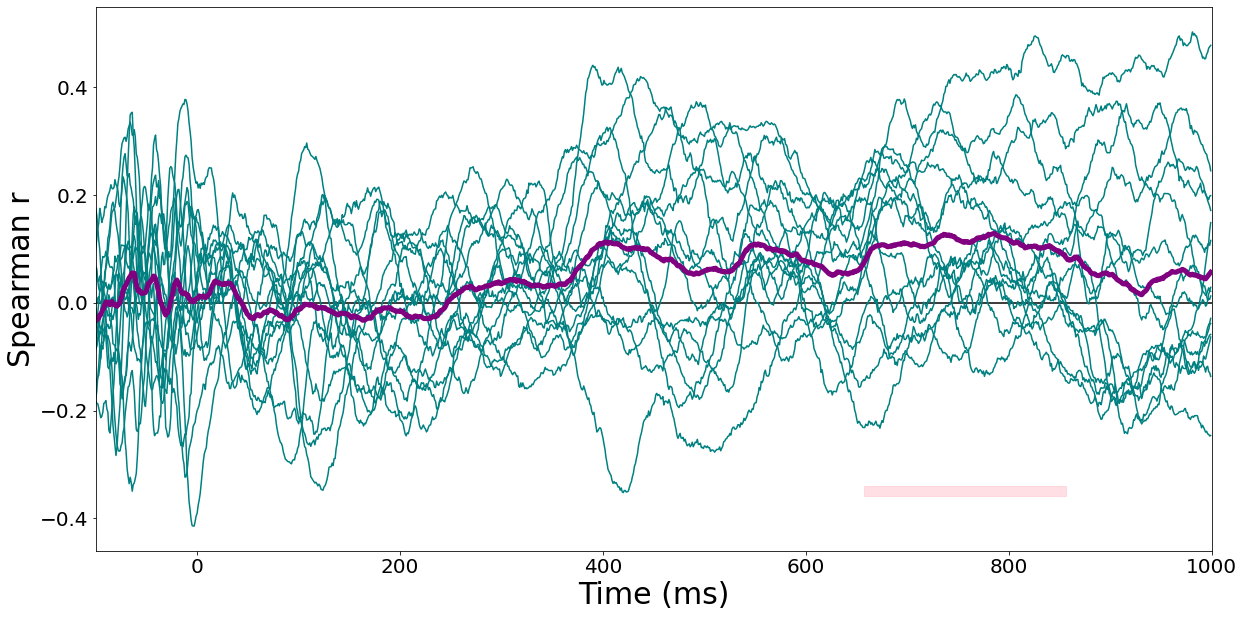

In [52]:
#Plotting all the correlations
times=range(0,epoch)
plt.figure(figsize=(20,10))
for i in range(0,bb):
    plt.plot(range(time_start-100,time_end-100),rvalues[i],color="teal")
plt.plot(range(time_start-100,time_end-100),avg_r, linewidth=5,color="purple", label="")
plt.subplot
for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = plt.axvspan(times[c.start]-100, times[c.stop - 1]-100,
                         color='pink', alpha=0.5,ymin=0.10,ymax=0.12)
plt.ylabel('Spearman r',fontsize=30)
plt.xlabel('Time (ms)',fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.hlines(0, -100, 1000)
plt.xlim(-100,1000)
plt.show()